# 地理院タイルと標高データ

## ■ 参考URL
- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)

## ■ シンプルな例

### 1. import

In [1]:
import urllib
import os
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 地理院タイルをダウンロードする関数・arrayとして取り込む関数

In [1]:
def maybe_download(url, name):
    """ Download if not present."""
    if not os.path.exists(name):
        urllib.urlretrieve(url, name)
        print "File " + name + " downloaded!"
    return name

def read_tile(name):
    """ csv file -> numpy array """
    ret = np.genfromtxt(name, delimiter=",", filling_values=0.) # 'e'->0.0
    if ret.shape == (256, 256):
        return ret
    else: # 国外だとデータがないので0としておく
        return np.zeros((256, 256))

### 3. 標高タイルのダウンロード・読み込み

In [3]:
tile_info = [10, 907, 402] # zoom, x, y
url = "http://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt".format(z=tile_info[0], x=tile_info[1], y=tile_info[2])
filename = "csv/dem_{z}_{x}_{y}.csv".format(z=tile_info[0], x=tile_info[1], y=tile_info[2])
maybe_download(url, filename)
data = read_tile(filename)

### 4. 可視化

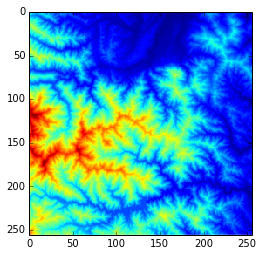

In [4]:
plt.imshow(data, interpolation="none")

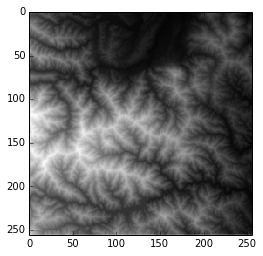

In [7]:
plt.imshow(data, interpolation="none", cmap="gray")

## ■ 勾配の計算

### 1. 勾配の向き・絶対値を各地点で取得

各方向への偏微分は以下のように求められる。
$$
\begin{align}
(\frac{\partial f}{\partial x}) \simeq \frac{f(x+h) - f(x-h)}{2h} \\
(\frac{\partial f}{\partial y}) \simeq \frac{f(y+h) - f(y-h)}{2h}
\end{align}
$$
これを用いて、勾配の角度と絶対値は以下のようになる。
$$
\begin{align}
\theta = arctan(\frac{\partial f / \partial y}{\partial f / \partial x}) \\
|\;grad\;| = \sqrt{(\frac{\partial f}{\partial x})^2 + (\frac{\partial f}{\partial y})^2}
\end{align}
$$

In [5]:
# x, y, thetaの向きに注意
g_theta = np.zeros(data.shape)
g_norm = np.zeros(data.shape)
for i in range(1, data.shape[0]-1):
    for j in range(1, data.shape[1]-1):
        dy = (data[i+1][j]-data[i-1][j]) / 2.
        dx = (data[i][j+1]-data[i][j-1]) / 2.
        g_theta[i][j] = math.atan2(dy, dx)
        g_norm[i][j]  = math.sqrt(dx*dx+dy*dy)

### 2. 可視化

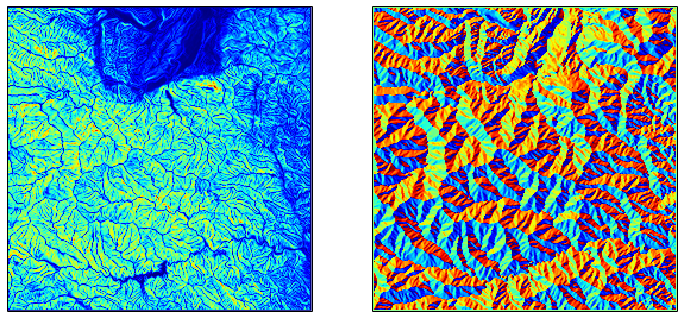

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(g_norm, interpolation="none")
ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(g_theta, interpolation="none")

### 3. 関数にする

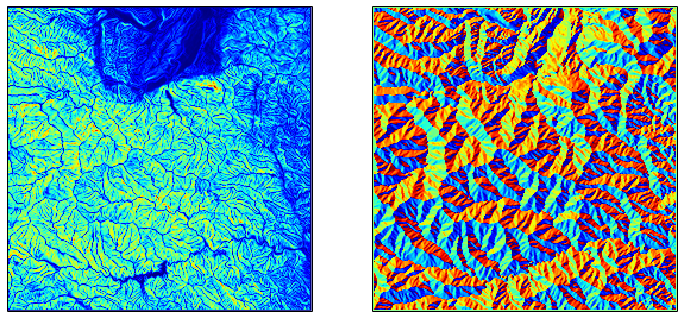

In [7]:
def calc_grad(data):
    # x, y, thetaの向きに注意
    g_theta = np.zeros(data.shape)
    g_norm = np.zeros(data.shape)
    for i in range(1, data.shape[0]-1):
        for j in range(1, data.shape[1]-1):
            dy = (data[i+1][j]-data[i-1][j]) / 2.
            dx = (data[i][j+1]-data[i][j-1]) / 2.
            g_theta[i][j] = math.atan2(dy, dx)
            g_norm[i][j]  = math.sqrt(dx*dx+dy*dy)
    return g_theta, g_norm

# Usage
t, n = calc_grad(data)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(n, interpolation="none")
ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(t, interpolation="none")

## ■ 任意の領域・ズームレベルで標高タイルを取得する

### 1. 領域の定義
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)を開き、長方形領域の左上と右下のタイル座標を好きなズームレベルで指定する。
- 例えば、以下の画像で5/27/11から5/28/13までの縦長領域に関して好きなズームレベルで標高タイルを取得したいとする。
<img src="fig/japan.png" width="500">

In [8]:
# from 5/27/11 to 5/28/13
tile_area = {}
tile_area["from"] = [5, 27, 11]
tile_area["to"] = [5, 28, 13]

print tile_area
print "# of tiles: ", (tile_area["to"][1] - tile_area["from"][1] + 1) * (tile_area["to"][2] - tile_area["from"][2] + 1)

{'to': [5, 28, 13], 'from': [5, 27, 11]}
# of tiles:  6


### 2. タイル座標の取得
上記で指定した領域について、任意のズームレベルにおけるタイル座標をすべて取得する。

ズームレベルを1つ増やすごとにタイルが4倍になり、下図のようにタイル座標が変化することに注意。
<img src="fig/zoom.jpg" width="400">

In [9]:
MAX_ZOOM = 18
zoom = 7

assert zoom <= MAX_ZOOM

# 指定されたzoomにおける左上のタイル座標
x1 = tile_area["from"][1] * 2**(zoom - tile_area["from"][0])
y1 = tile_area["from"][2] * 2**(zoom - tile_area["from"][0])
# 指定されたzoomにおける右下のタイル座標
x2 = (tile_area["to"][1] + 1) * 2**(zoom - tile_area["to"][0]) - 1 # すぐ右下を考え、それから-1
y2 = (tile_area["to"][2] + 1) * 2**(zoom - tile_area["to"][0]) - 1 # すぐ右下を考え、それから-1
print x1, y1, x2, y2
print "# of tiles: ", (x2 - x1 + 1) * (y2 - y1 + 1)

# 左上〜右下すべてのタイルの座標
tile_list = []
for j in range(y1, y2+1):
    tile_row = []
    for i in range(x1, x2+1):
        tile_row.append([zoom, i, j])
    tile_list.append(tile_row)

print len(tile_list), len(tile_list[0])
print tile_list[0][:3]
print tile_list[-1][-4:]

108 44 115 55
# of tiles:  96
12 8
[[7, 108, 44], [7, 109, 44], [7, 110, 44]]
[[7, 112, 55], [7, 113, 55], [7, 114, 55], [7, 115, 55]]


### 3. タイルのダウンロード

In [10]:
full_tile = []
for tile_row in tile_list:
    tr = []
    for tile in tile_row:
        tile_url = "http://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt".format(z=tile[0], x=tile[1], y=tile[2])
        tile_name = "csv/dem_{z}_{x}_{y}.csv".format(z=tile[0], x=tile[1], y=tile[2])
        maybe_download(tile_url, tile_name)
        tr.append(read_tile(tile_name)) # 'e'->0.0
    full_tile.append(np.hstack(tr))
full_tile = np.vstack(full_tile)

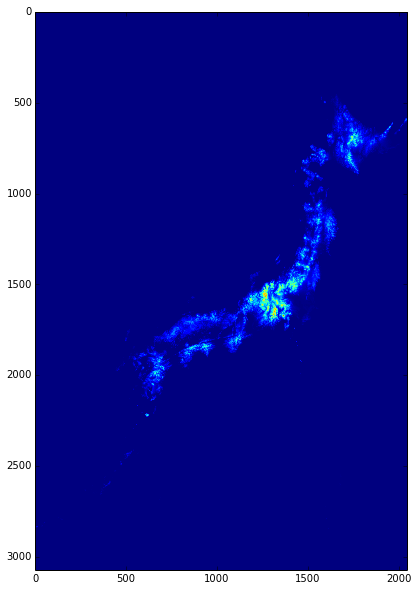

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(full_tile)

### 4. 関数にする

In [81]:
def get_tiles(from_tile, to_tile=None, zoom=None):
    if zoom == None:# zoomを省略するとfrom_tileと同じになる
        zoom =from_tile[0]
    if to_tile == None:# to_tileを省略するとfrom_tileと同じになる
        to_tile = from_tile
    MAX_ZOOM = 18
    assert zoom <= MAX_ZOOM

    # 指定されたzoomにおける左上のタイル座標
    x1 = from_tile[1] * 2**(zoom - from_tile[0])
    y1 = from_tile[2] * 2**(zoom - from_tile[0])
    # 指定されたzoomにおける右下のタイル座標
    x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    
    # 左上〜右下すべてのタイルの座標
    tile_list = []
    for j in range(y1, y2+1):
        tile_row = []
        for i in range(x1, x2+1):
            tile_row.append([zoom, i, j])
        tile_list.append(tile_row)
    
    # ダウンロード
    full_tile = []
    for tile_row in tile_list:
        tr = []
        for tile in tile_row:
            tile_url = "http://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt".format(z=tile[0], x=tile[1], y=tile[2])
            tile_name = "csv/dem_{z}_{x}_{y}.csv".format(z=tile[0], x=tile[1], y=tile[2])
            maybe_download(tile_url, tile_name)
            tr.append(read_tile(tile_name)) # 'e'->0.0
        full_tile.append(np.hstack(tr))
    full_tile = np.vstack(full_tile)
    return full_tile

### 5. 勾配計算と合わせてみる

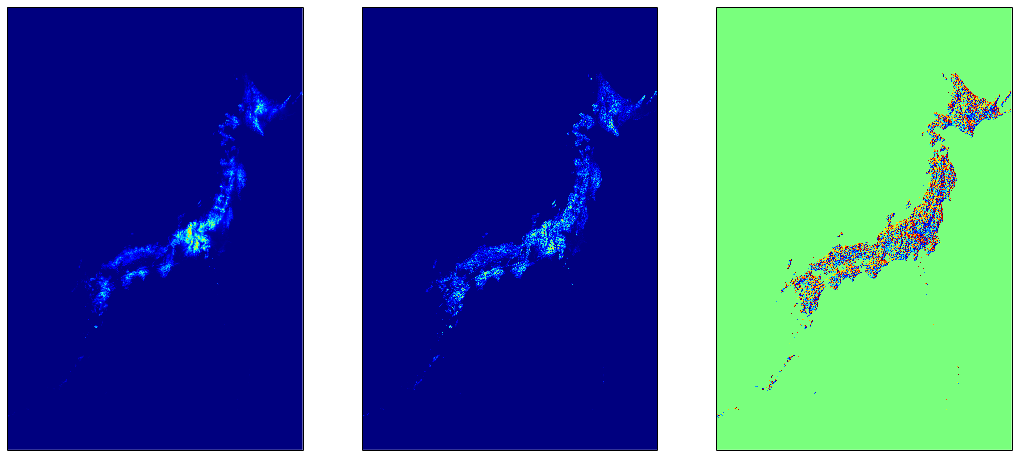

In [82]:
# Japan
japan_tile = get_tiles([5, 27, 11], [5, 28, 13], 7)

t, n = calc_grad(japan_tile)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(japan_tile, interpolation="none")
ax2 = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax2.imshow(n, interpolation="none")
ax3 = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax3.imshow(t, interpolation="none")

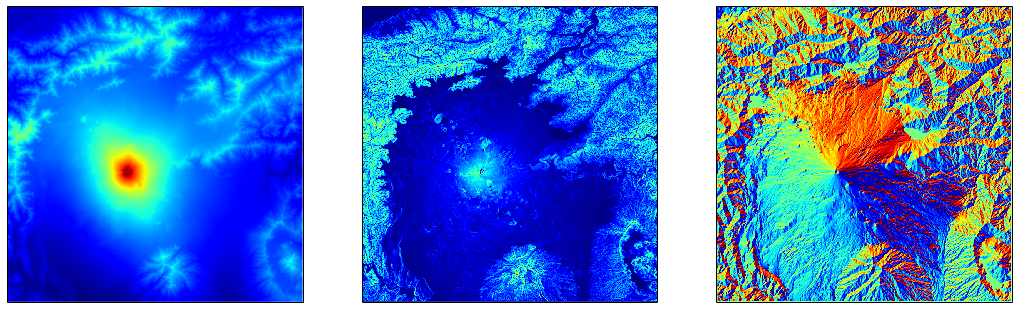

In [83]:
# Mt. Fuji
fuji_tile = get_tiles([11, 1812, 807], [11, 1814, 809])

t, n = calc_grad(fuji_tile)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(fuji_tile, interpolation="none")
ax2 = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax2.imshow(n, interpolation="none")
ax3 = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax3.imshow(t, interpolation="none")

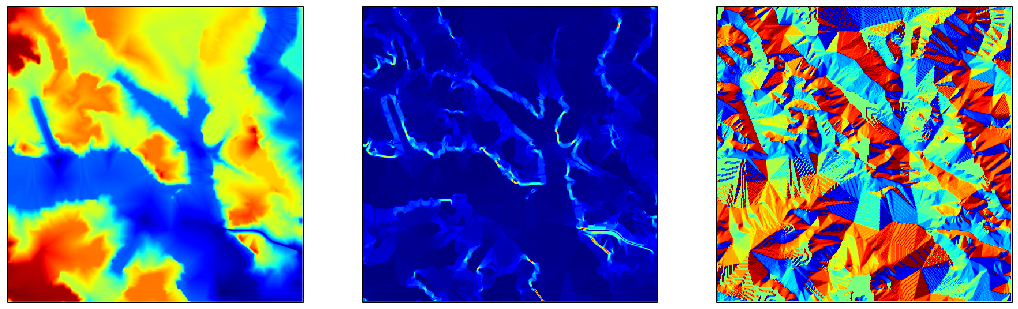

In [84]:
# Tokyo
tokyo_tile = get_tiles([14, 14551, 6449], [14, 14552, 6450])

t, n = calc_grad(tokyo_tile)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(tokyo_tile, interpolation="none")
ax2 = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax2.imshow(n, interpolation="none")
ax3 = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax3.imshow(t, interpolation="none")

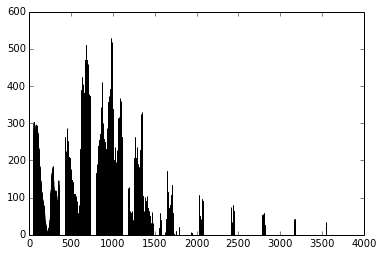

In [16]:
plt.hist(fuji_tile)
plt.show()

## ■ 緯度・経度

### 1. タイル座標と緯度・経度の関係
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)

    - 世界測地系の経緯度が正方形に変換されるよう極域の一部地域（北緯及び南緯約85.0511度以上）を除外した範囲について、 メルカトル投影の数式を使って変換したものが「ズームレベル0」

    - 西経180度、北緯約85.0511度の北西端を端点にもつタイル画像を(0,0)として東方向をX正方向、南方向をY正方向にとる。
    <img src="fig/tileNum.png" width="400">


- [メルカトル図法 - Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E3%82%AB%E3%83%88%E3%83%AB%E5%9B%B3%E6%B3%95)
    - 地図の中央の経度が$\lambda_0$であるとき、半径を1とする単位球面における地理経緯度$ \lambda,\,\varphi$の点が投影されるメルカトル図法の地図上の点$X,\,Y$は、
$$
\begin{align}
X = \lambda - \lambda_0  \\
Y = tanh^{-1}sin(\varphi)
\end{align}
$$
    - 逆に、図上位置$X,\,Y$から緯度と経度を求める式は以下の通り。
$$
\begin{align}
\lambda = X +  \lambda_0  \\
\varphi = sin^{-1}tanh(Y)
\end{align}
$$


- 経度$\lambda$と$X, x$の関係は線形になっている。タイル座標から経度を求めたい。
    - ズームレベルzとすると、タイル1つの占める経度は$\frac{360}{2^z}$
    - z/x/yの左上点、すなわちズームレベルzとしたときにタイル座標(x, y)となるタイルの左上点では、西経をマイナスとして
    $$
    \begin{align}
    \lambda = -180 + \frac{360}{2^z} x \: [deg]
    \end{align}
    $$
- 緯度$\varphi$と$Y, y$の関係は少し面倒。タイル座標から緯度を求めたい。
    - 地理院タイルにおいては経度が-85.0511度〜85.0511度であるため、$Y$の範囲は
    
    $$
    \begin{align}
    tanh^{-1}sin(-85.0511\times(\pi/180)) \leq Y \leq tanh^{-1}sin(85.0511\times(\pi/180))
    \end{align}
    $$
    
    $max\_Y = tanh^{-1}sin(85.0511\times(\pi/180))$と定めると$max\_Y \simeq 3.14158683094$であり、
    
    $$
    \begin{align}
    -max\_Y \leq Y \leq max\_Y
    \end{align}
    $$
    と表せる。

    - タイル1つの占める地図上のYは$\frac{2\times max\_Y}{2^z}$であるから、タイル座標yのタイルの左上点は地図上の$Y = max\_Y - \frac{2\times max\_Y}{2^z} y$に相当する。

    - これを緯度に直すと、
$$
\begin{align}
\varphi = sin^{-1}tanh(max\_Y - \frac{2\times max\_Y}{2^z} y) \: [rad]
\end{align}
$$


- 逆に、緯度と経度を与えられたとき、その点はズームレベルzのもとでどのタイルに存在するかが知りたい。
    - 緯度が$\varphi$, 経度が$\lambda$である点は、地図上では以下の点$(X, Y)$にある。
    $$
    \begin{align}
    X = \lambda \\
    Y = tanh^{-1}sin(\varphi)
    \end{align}
    $$    
    - この点は以下のタイル座標(x, y)をもつタイル上に存在する
    $$
    \begin{align}
    x = \lfloor \frac{ X + 180 }{ \frac{360}{2^z} } \rfloor \\
    y = \lfloor \frac{max\_Y - Y}{\frac{2\times max\_Y}{2^z}} \rfloor
    \end{align}
    $$

In [45]:
def tile_to_latlng(tile):
    """ タイル座標を受けて、そのタイルの左上、右下における緯度と経度を[deg]で返す """
    max_lat = 85.0511
    mr = max_lat*(math.pi/180.) # max_lat: deg -> rad
    max_Y = math.atanh(math.sin(mr))
    z, x, y = tile # split args
    
    # Top left
    lat = math.asin(math.tanh(max_Y - y * (2*max_Y/(2**z)))) # [rad]
    lat = lat*180./math.pi # [deg]
    lng = -180. + x * (360. / (2**z)) # [deg]
    
    # Bottom right
    lat2 = math.asin(math.tanh(max_Y - (y+1) * (2*max_Y/(2**z)))) # [rad]
    lat2 = lat2*180./math.pi # [deg]
    lng2 = -180. + (x+1) * (360. / (2**z)) # [deg]
    
    return lat, lng, lat2, lng2


In [51]:
def latlng_map(tile):
    """ タイル座標を受けて、そのタイルの各ピクセル(256x256)中央における緯度と経度のarrayを返す """
    max_lat = 85.0511
    mr = max_lat*(math.pi/180.)　# max_lat: deg -> rad
    max_Y = math.atanh(math.sin(mr))
    z, x, y = tile　# split args
    ret = np.zeros((256, 256, 2)) # return this
    
    for i in range(ret.shape[0]):
        for j in range(ret.shape[1]):
            lat = math.asin(math.tanh(max_Y - (y + (i+0.5)/256.) * (2*max_Y/(2**z)))) # [rad]
            lat = lat*180./math.pi # [deg]
            lng = -180. + (x + (j+0.5)/256.) * (360. / (2**z)) # [deg]
            ret[i][j][0] = lat
            ret[i][j][1] = lng
    return ret

In [66]:
def latlng_to_tile(lat, lng, z):
    """ 緯度と経度とズームレベルを受けて、そのズームレベルにおいて与えられた緯度経度の点を含むタイルのタイル座標を返す """
    max_lat = 85.0511
    mr = max_lat*(math.pi/180.) # max_lat: deg -> rad
    max_Y = math.atanh(math.sin(mr))
    
    assert (-max_lat<=lat<=max_lat) and (-180<=lng<=180) and (0<=z<=18)
    
    X = lng # [deg], -180 to +180
    Y = math.atanh(math.sin(lat*math.pi/180.)) # lat: [deg], -85.0511 to 85.0511
    
    _x = int( math.floor( (X + 180) / (360. / (2**z)) ))
    _y = int( math.floor( (max_Y - Y) / (2*max_Y / (2**z)) ))
    return _x, _y

In [67]:
print latlng_to_tile(35.563512,139.993973, 10)

(910, 403)


In [63]:
print tile_to_latlng([2, 3, 3])
print tile_to_latlng([9, 454, 201])

(-42.525549999999996, 90.0)
(18.272697265625, 139.21875)


### 2. 緯度と経度を与えてプロット

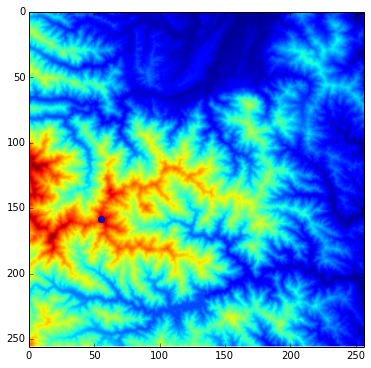

In [195]:
tile_coord = [10, 907, 402] # kumotori tile
sample_tile = get_tiles(tile_coord)
sample_map = latlng_map(tile_coord)

# check latlng_to_tile
for i in range(sample_map.shape[0]):
    for j in range(sample_map.shape[1]):
        assert latlng_to_tile(sample_map[i][j][0], sample_map[i][j][1], tile_coord[0]) == (tile_coord[1], tile_coord[2])

# kumotori peak
klat = 35.855492 
klng = 138.943909
assert latlng_to_tile(klat, klng, 10) == (tile_coord[1], tile_coord[2]) # assert that kumotori peak is in the sample_tile

# Nearest Neighbor
flat_map = sample_map.reshape((sample_map.shape[0]*sample_map.shape[1], sample_map.shape[2]))
dists = np.array([np.linalg.norm(p-[klat, klng], ord=2) for p in flat_map])

# Nearest pixel x,y
x = [np.argmin(dists) %  256]
y = [np.argmin(dists) // 256]

# plot
fig = plt.figure(figsize=(6, 6))
plt.xlim(0, sample_tile.shape[1])
plt.ylim(sample_tile.shape[0],0)
plt.imshow(sample_tile)
plt.hold(True)
plt.plot(x, y, 'o')

### 3. 地理院地図で作図したルートのプロット
#### (1) 地理院地図でpathを普通に描画する
#### (2) chiri.htmlとしてdownloadし、以下のコードで点列をprint

In [211]:
from bs4 import BeautifulSoup
import json

filename="chiri.html"
soup = BeautifulSoup(open(filename,'r').read(), "lxml")
data = soup.path.attrs["d"]
points = [p.split(" ") for p in data[1:].split("L")]
points = [[float(n) for n in p] for p in points]
#f = open("data.json", "w")
#json.dump(points, f)
#f.close()
print points

[[-1456.0, 65.0], [-1461.0, 73.0], [-1461.0, 77.0], [-1459.0, 79.0], [-1460.0, 92.0], [-1458.0, 99.0], [-1454.0, 108.0], [-1446.0, 112.0], [-1442.0, 117.0], [-1428.0, 147.0], [-1429.0, 155.0], [-1433.0, 161.0], [-1432.0, 179.0], [-1435.0, 193.0], [-1433.0, 199.0], [-1417.0, 222.0], [-1404.0, 234.0], [-1401.0, 241.0], [-1373.0, 265.0], [-1369.0, 270.0], [-1367.0, 276.0], [-1361.0, 280.0], [-1354.0, 282.0], [-1351.0, 285.0], [-1350.0, 290.0], [-1338.0, 293.0], [-1306.0, 277.0], [-1298.0, 279.0], [-1277.0, 292.0], [-1263.0, 287.0], [-1257.0, 287.0], [-1244.0, 280.0], [-1237.0, 278.0], [-1222.0, 266.0], [-1218.0, 277.0], [-1211.0, 284.0], [-1204.0, 286.0], [-1194.0, 286.0], [-1184.0, 295.0], [-1176.0, 299.0], [-1170.0, 300.0], [-1157.0, 295.0], [-1139.0, 297.0], [-1129.0, 301.0], [-1102.0, 301.0], [-1092.0, 297.0], [-1081.0, 297.0], [-1073.0, 295.0], [-1056.0, 288.0], [-1053.0, 290.0], [-1043.0, 305.0], [-1036.0, 306.0], [-1025.0, 328.0], [-1017.0, 335.0], [-999.0, 327.0], [-984.0, 333.0],

#### (3) printした内容をconsoleにコピペしてhoge=(貼り付けたやつ)とする
#### (4) consoleで以下を実行するとaに緯度経度がはいる

```
$ a = []
$ for (var p of hoge){a.push([GSI.GLOBALS.map.layerPointToLatLng(L.point(p[0], p[1]))["lat"], GSI.GLOBALS.map.layerPointToLatLng(L.point(p[0], p[1]))["lng"]]);}
$ for (var i of a){ console.log(i)}
```


In [212]:
a = """[35.860952532806905, 138.9437484741211]
VM1039:1 [35.85983955355435, 138.94289016723633]
VM1039:1 [35.85928305806782, 138.94289016723633]
VM1039:1 [35.859004808859524, 138.94323348999023]
VM1039:1 [35.85719616519874, 138.94306182861328]
VM1039:1 [35.8562222630588, 138.9434051513672]
VM1039:1 [35.854970085584675, 138.944091796875]
VM1039:1 [35.854413555914604, 138.94546508789062]
VM1039:1 [35.8537178883334, 138.94615173339844]
VM1039:1 [35.849543754664644, 138.94855499267578]
VM1039:1 [35.848430615242236, 138.94838333129883]
VM1039:1 [35.84759575042136, 138.94769668579102]
VM1039:1 [35.84509110322453, 138.94786834716797]
VM1039:1 [35.84314298960749, 138.9473533630371]
VM1039:1 [35.84230806912384, 138.94769668579102]
VM1039:1 [35.83910745918766, 138.95044326782224]
VM1039:1 [35.83743752447774, 138.95267486572266]
VM1039:1 [35.836463379663414, 138.95318984985352]
VM1039:1 [35.833123363777666, 138.9579963684082]
VM1039:1 [35.832427509437316, 138.95868301391602]
VM1039:1 [35.83159247617366, 138.95902633666992]
VM1039:1 [35.831035782449284, 138.96005630493164]
VM1039:1 [35.83075743412253, 138.9612579345703]
VM1039:1 [35.830339909801715, 138.96177291870117]
VM1039:1 [35.82964403105181, 138.96194458007812]
VM1039:1 [35.829226500872785, 138.96400451660156]
VM1039:1 [35.831453303108695, 138.96949768066403]
VM1039:1 [35.831174956246535, 138.9708709716797]
VM1039:1 [35.829365677843214, 138.9744758605957]
VM1039:1 [35.830061559034036, 138.97687911987305]
VM1039:1 [35.830061559034036, 138.97790908813477]
VM1039:1 [35.831035782449284, 138.98014068603516]
VM1039:1 [35.83131412979967, 138.9813423156738]
VM1039:1 [35.83298419339778, 138.98391723632812]
VM1039:1 [35.831453303108695, 138.9846038818359]
VM1039:1 [35.83047908481941, 138.9858055114746]
VM1039:1 [35.83020073453991, 138.98700714111328]
VM1039:1 [35.83020073453991, 138.9887237548828]
VM1039:1 [35.828948146199636, 138.99044036865234]
VM1039:1 [35.8283914339243, 138.99181365966797]
VM1039:1 [35.82825225524526, 138.9928436279297]
VM1039:1 [35.828948146199636, 138.99507522583008]
VM1039:1 [35.82866979055014, 138.99816513061523]
VM1039:1 [35.82811307632212, 138.99988174438477]
VM1039:1 [35.82811307632212, 139.0045166015625]
VM1039:1 [35.82866979055014, 139.00623321533203]
VM1039:1 [35.82866979055014, 139.00812149047852]
VM1039:1 [35.828948146199636, 139.00949478149414]
VM1039:1 [35.82992238328405, 139.01241302490234]
VM1039:1 [35.82964403105181, 139.01292800903317]
VM1039:1 [35.82755635818869, 139.01464462280273]
VM1039:1 [35.82741717804514, 139.0158462524414]
VM1039:1 [35.82435515313399, 139.0177345275879]
VM1039:1 [35.82338084770657, 139.01910781860352]
VM1039:1 [35.82449433864731, 139.02219772338867]
VM1039:1 [35.82365922190618, 139.02477264404294]
VM1039:1 [35.823798408639895, 139.02803421020505]
VM1039:1 [35.82421596737658, 139.02923583984375]
VM1039:1 [35.82421596737658, 139.03181076049805]
VM1039:1 [35.82449433864731, 139.03284072875977]
VM1039:1 [35.82352003492841, 139.03369903564453]
VM1039:1 [35.822545719249895, 139.03661727905273]
VM1039:1 [35.82129301009018, 139.03833389282227]
VM1039:1 [35.82059705201462, 139.03987884521482]
VM1039:1 [35.820040281161, 139.04022216796875]
VM1039:1 [35.820179474240504, 139.04159545898438]
VM1039:1 [35.819205117558695, 139.0436553955078]
VM1039:1 [35.818787532462686, 139.04571533203125]
VM1039:1 [35.81823074891787, 139.04674530029297]
VM1039:1 [35.81823074891787, 139.04794692993164]
VM1039:1 [35.81739556627887, 139.04657363891602]
VM1039:1 [35.81823074891787, 139.04829025268555]
VM1039:1 [35.818926727738734, 139.0506935119629]
VM1039:1 [35.818787532462686, 139.05206680297852]
VM1039:1 [35.81823074891787, 139.05292510986328]
VM1039:1 [35.81823074891787, 139.05344009399414]
VM1039:1 [35.81767396146809, 139.0542984008789]
VM1039:1 [35.81711717011343, 139.05601501464844]
VM1039:1 [35.81642117542884, 139.0568733215332]
VM1039:1 [35.81558597375359, 139.05704498291016]
VM1039:1 [35.81433315476729, 139.0597915649414]
VM1039:1 [35.81349793112761, 139.06064987182617]
VM1039:1 [35.81405474786358, 139.06373977661133]
VM1039:1 [35.81377633998367, 139.0645980834961]
VM1039:1 [35.813219521295345, 139.0652847290039]
VM1039:1 [35.81294111048691, 139.06648635864258]
VM1039:1 [35.81363713567767, 139.06854629516602]
VM1039:1 [35.81363713567767, 139.06940460205078]
VM1039:1 [35.811827457491454, 139.07215118408203]
VM1039:1 [35.81001773806242, 139.0736961364746]
VM1039:1 [35.80960010464499, 139.07575607299805]
VM1039:1 [35.80960010464499, 139.07730102539062]
VM1039:1 [35.80987852716731, 139.07798767089844]
VM1039:1 [35.81001773806242, 139.07970428466797]
VM1039:1 [35.81057457920248, 139.08090591430664]
VM1039:1 [35.810992207495154, 139.08296585083008]
VM1039:1 [35.810713788877415, 139.08330917358398]
VM1039:1 [35.809043256671956, 139.08227920532227]
VM1039:1 [35.80960010464499, 139.08416748046875]
VM1039:1 [35.80862561812983, 139.08605575561523]
VM1039:1 [35.808347191214935, 139.08605575561523]
VM1039:1 [35.80820797739145, 139.08571243286133]
VM1039:1 [35.80792954901235, 139.08657073974607]
VM1039:1 [35.807790334456776, 139.08605575561523]
VM1039:1 [35.807511904613506, 139.08674240112305]
VM1039:1 [35.80820797739145, 139.0872573852539]
VM1039:1 [35.808347191214935, 139.08777236938477]
VM1039:1 [35.80792954901235, 139.08966064453125]
VM1039:1 [35.80765111965714, 139.08794403076172]
VM1039:1 [35.807094258018395, 139.08777236938477]
VM1039:1 [35.806537392475214, 139.0862274169922]
VM1039:1 [35.806537392475214, 139.08485412597656]
VM1039:1 [35.806258958239475, 139.08828735351562]
VM1039:1 [35.80500599209946, 139.09034729003906]
VM1039:1 [35.805423649675674, 139.09137725830078]
VM1039:1 [35.80570208683969, 139.09154891967773]
VM1039:1 [35.80584130505568, 139.09223556518555]
VM1039:1 [35.806258958239475, 139.0917205810547]
VM1039:1 [35.80639817547936, 139.0924072265625]
VM1039:1 [35.806676609227054, 139.0924072265625]
VM1039:1 [35.807790334456776, 139.09429550170898]
VM1039:1 [35.80792954901235, 139.09549713134766]
VM1039:1 [35.807511904613506, 139.0956687927246]
VM1039:1 [35.808347191214935, 139.09704208374023]
VM1039:1 [35.80960010464499, 139.09635543823242]"""


b = """[35.85524834895473, 138.94392013549805]
VM602:1 [35.82978320728997, 138.96623611450192]
VM602:1 [35.830061559034036, 139.01275634765625]
VM602:1 [35.81739556627887, 139.04657363891602]
VM602:1 [35.80932168114654, 139.0975570678711]"""
import re
aa = re.split(r"[\[\]]", a)
# print [i.split(",") for i in aa if len(i.split(","))==2]
path = np.array([ [float(n) for n in i.split(",")] for i in aa if len(i.split(","))==2]) 
print path

[[  35.86095253  138.94374847]
 [  35.85983955  138.94289017]
 [  35.85928306  138.94289017]
 [  35.85900481  138.94323349]
 [  35.85719617  138.94306183]
 [  35.85622226  138.94340515]
 [  35.85497009  138.9440918 ]
 [  35.85441356  138.94546509]
 [  35.85371789  138.94615173]
 [  35.84954375  138.94855499]
 [  35.84843062  138.94838333]
 [  35.84759575  138.94769669]
 [  35.8450911   138.94786835]
 [  35.84314299  138.94735336]
 [  35.84230807  138.94769669]
 [  35.83910746  138.95044327]
 [  35.83743752  138.95267487]
 [  35.83646338  138.95318985]
 [  35.83312336  138.95799637]
 [  35.83242751  138.95868301]
 [  35.83159248  138.95902634]
 [  35.83103578  138.9600563 ]
 [  35.83075743  138.96125793]
 [  35.83033991  138.96177292]
 [  35.82964403  138.96194458]
 [  35.8292265   138.96400452]
 [  35.8314533   138.96949768]
 [  35.83117496  138.97087097]
 [  35.82936568  138.97447586]
 [  35.83006156  138.97687912]
 [  35.83006156  138.97790909]
 [  35.83103578  138.98014069]
 [  35.8

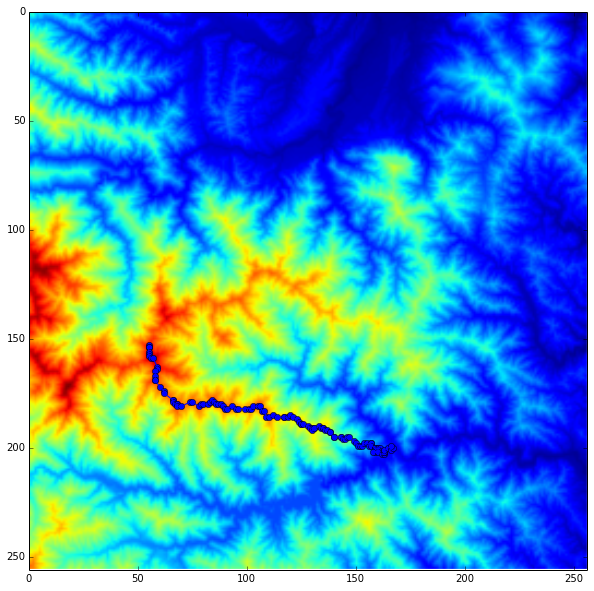

In [213]:
tile_coord = [10, 907, 402] # kumotori tile
sample_tile = get_tiles(tile_coord)
sample_map = latlng_map(tile_coord)

# kumotori path
#for p in path:
    #assert latlng_to_tile(p[0], p[1], 10) == (tile_coord[1], tile_coord[2]) # assert that kumotori peak is in the sample_tile

x = []
y = []

flat_map = sample_map.reshape((sample_map.shape[0]*sample_map.shape[1], sample_map.shape[2]))

for p in path:
    # Nearest Neighbor
    dists = np.array([np.linalg.norm(pixel-[p[0], p[1]], ord=2) for pixel in flat_map])

    # Nearest pixel x,y
    x.append(np.argmin(dists) %  256)
    y.append(np.argmin(dists) // 256)

# plot
fig = plt.figure(figsize=(10, 10))
plt.xlim(0, sample_tile.shape[1])
plt.ylim(sample_tile.shape[0],0)
plt.imshow(sample_tile)
plt.hold(True)
plt.plot(x, y, 'o', color="blue")
plt.plot(x, y, '-', color="blue")

In [ ]:
# zoomlevel13ぐらいでやらないと合わないような？

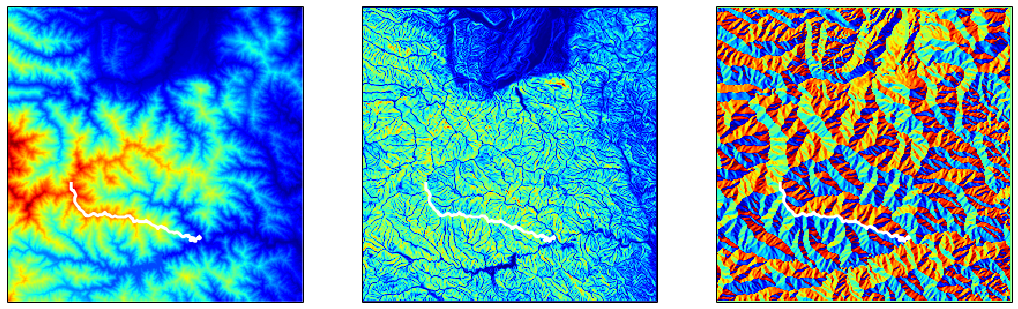

In [222]:

t, n = calc_grad(sample_tile)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(sample_tile, interpolation="none")
plt.hold(True)
plt.plot(x, y, '-', color="white", linewidth="3")
ax2 = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax2.imshow(n, interpolation="none")
plt.hold(True)
plt.plot(x, y, '-', color="white", linewidth="3")
ax3 = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax3.imshow(t, interpolation="none")
plt.hold(True)
plt.plot(x, y, '-', color="white", linewidth="3")